# OWF site location optimisation

* Optimise according to physical restraints (depth), and according to simulated performance across a range of sample days (energy potential of the site).

In [1]:
import tensorflow as tf
import os
from os.path import exists
from tensorflow.python.keras.models import load_model
from platypus import NSGAII, Problem, Real, nondominated
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.basemap import Basemap
import joblib
from matplotlib import path
from matplotlib.patches import Polygon

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
class OWF(Problem):
    def __init__(self, lat_limits, long_limits, data):
        """ Locate optimal location (lat and long) in an area, to maximise 
        Nvars: 8 (4 sets of lat and long to define bounding box)
        Nobjs: 3 (depth, wind potential of site, size of site)
        #Nconstraints: 2 (depth and wind potential of site)
        """
        super(OWF, self).__init__(8, 3)

        self.lat_limits = lat_limits
        self.long_limits = long_limits
        
        # only predict locations within the site boundaries
        # allow predictions to be Real numbers (i.e. floats)
        self.types = [
            Real(self.lat_limits[0], self.lat_limits[1]),   # 1 lat
            Real(self.long_limits[0], self.long_limits[1]), # 1 long
            Real(self.lat_limits[0], self.lat_limits[1]),   # 2 lat
            Real(self.long_limits[0], self.long_limits[1]), # 2 long
            Real(self.lat_limits[0], self.lat_limits[1]),   # 3 lat
            Real(self.long_limits[0], self.long_limits[1]), # 3 long
            Real(self.lat_limits[0], self.lat_limits[1]),   # 4 lat
            Real(self.long_limits[0], self.long_limits[1]), # 4 long
        ]

        self.directions = [
            Problem.MAXIMIZE,   # maximise depth (all depths are negative)
            Problem.MAXIMIZE,  # maximise wind potential
            Problem.MINIMIZE,  # minimise area used
        ]

        #self.constraints = [
        #    "<=25",  # limited to depth of max 25m
        #    #">0",   # no constraints to wind potential
        #]

        self.data = data

    def evaluate(self, solution):
        x = solution.variables[:]

        coords = pd.DataFrame(columns=['Lat', 'Lon'])
        coords['Lat'] = x[0::2] # set every other element to lat (from index 0)
        coords['Lon'] = x[1::2] # set every other element to long (from index 1)

        # sort coords so they form a bounding box
        coords = coords.sort_values(by=['Lat', 'Lon'])
        coords = coords.reset_index(drop=True)

        # difference between each coordinate and the next
        first = coords['Lat'][0]*coords['Lon'][1] + coords['Lat'][1]*coords['Lon'][2] + coords['Lat'][2]*coords['Lon'][3] + coords['Lat'][3]*coords['Lon'][0]
        second = coords['Lat'][1]*coords['Lon'][0] + coords['Lat'][2]*coords['Lon'][1] + coords['Lat'][3]*coords['Lon'][2] + coords['Lat'][0]*coords['Lon'][3]
        area = 0.5 * (first - second)

        # define polygon as path
        polygon = path.Path([[coords['Lat'][0], coords['Lon'][0]], [coords['Lat'][1], coords['Lon'][1]], [coords['Lat'][2], coords['Lon'][2]], [coords['Lat'][3], coords['Lon'][3]]])

        # get data within polygon
        data_polygon = self.data[polygon.contains_points(self.data[['Lat', 'Lon']].values)]

        # dataframe is empty, because no data at that location (out of bounds / too small), set depth and wind potential to -inf
        if data_polygon.empty:
            depth = -np.inf
            wind_potential = -np.inf

        else:
            # get average depth from bathymetric data polygon
            depth = data_polygon['Depth'].mean()

            # get average wind potential from wind data polygon
            wind_potential = data_polygon['Chi'].mean()

        solution.objectives[:] = [depth, wind_potential, area]    # solution objective scores relative to depth and wind potential of site
        #solution.constraints[:] = [depth, wind_potential]   # can later search for feasible solutions, constrained by depth and wind potential

In [4]:
data = pd.read_csv('data/UK east coast.csv')

data_lat_range = (min(data['Lat']), max(data['Lat']))
data_long_range = (min(data['Lon']), max(data['Lon']))

print(f"Latitude range: {data_lat_range}, Longitude range: {data_long_range}")

Latitude range: (53.486257927, 54.8083537), Longitude range: (-0.5269085, 2.5571098)


In [5]:
# load the problem
problem = OWF(
    lat_limits=data_lat_range, 
    long_limits=data_long_range, 
    data=data,
)

In [18]:
# run the optimisation
algorithm = NSGAII(problem)
algorithm.run(10000)

In [19]:
nondominated_solutions = nondominated(algorithm.result)
Y = np.array([s.objectives for s in nondominated_solutions])

In [28]:
# convert results to pandas dataframe
results = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'Depth', 'Wind Potential', 'Area'])

# read nondominated solutions into dataframe
for i, solution in enumerate(nondominated_solutions):
    results.loc[i] = [*solution.variables[:], *solution.objectives]

print(results)

           x1        y1         x2        y2         x3        y3         x4  \
0   53.496060  2.523786  54.784923  2.555898  54.806068 -0.519818  53.491618   
1   53.555196  2.548170  54.802308  2.556422  54.738940  1.441873  53.671672   
2   54.731546  2.390789  54.797085  2.556252  54.092386  2.554231  53.496436   
3   54.306489 -0.444460  53.717432  0.631922  53.487456 -0.476078  53.525884   
4   53.514153  2.552446  54.774333  2.555347  54.802139  1.591011  53.509636   
..        ...       ...        ...       ...        ...       ...        ...   
95  54.301024 -0.445742  53.728561  0.654584  53.487327  0.468570  53.486544   
96  53.496060  2.508493  54.802111  2.555640  54.806068  0.464016  53.488607   
97  53.700586  2.509803  54.804550  2.552115  54.804659  1.466931  53.613359   
98  53.535262  2.556352  54.751252  2.518777  54.762028  1.698527  53.509535   
99  53.504345  2.549699  54.794672  2.551901  53.487142  0.505816  53.528238   

          y4      Depth  Wind Potential

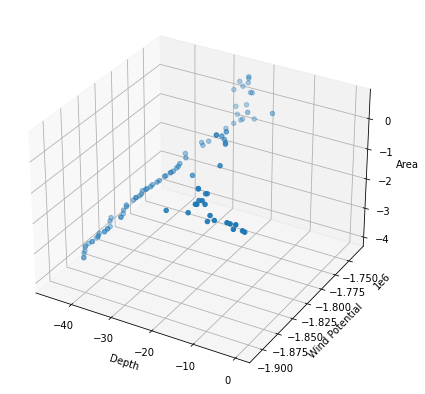

In [29]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2])
ax.set_xlabel('Depth')
ax.set_ylabel('Wind Potential')
ax.set_zlabel('Area')
plt.show()

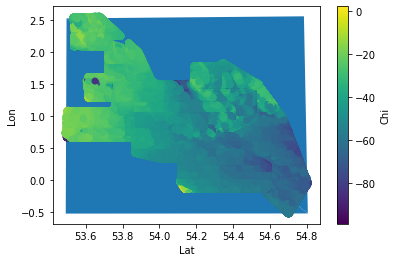

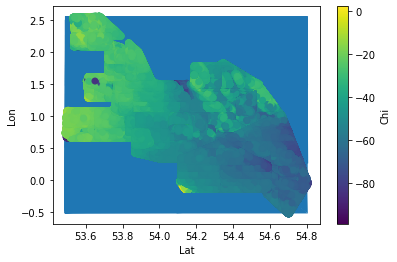

In [31]:
## plot Lat and Long and Depth, colored by Depth
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(results['Lat'], results['Lon'], results['Depth'], c=results['Wind Potential'], cmap='jet')
#ax.set_xlabel('Lat')
#ax.set_ylabel('Lon')
#ax.set_zlabel('Depth')
#plt.show()

## plot Lat and Long and Depth, colored by Depth
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(data['Lat'], data['Lon'], data['Depth'], c=data['Depth'], cmap='viridis')
#ax.scatter(results['Lat'], results['Lon'], results['Depth'], c='red')
#ax.set_xlabel('Lat')
#ax.set_ylabel('Lon')
#ax.set_zlabel('Depth')
#plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)

xy1, xy2, xy3, xy4 = (results.loc[0][0], results.loc[0][1]), (results.loc[0][2], results.loc[0][3]), (results.loc[0][4], results.loc[0][5]), (results.loc[0][6], results.loc[0][7])
p1 = Polygon(np.array([xy1, xy2, xy3]), closed=False)
p2 = Polygon(np.array([xy4, xy3, xy1]), closed=False)
ax.add_patch(p1)
ax.add_patch(p2)

map = ax.scatter(data['Lat'], data['Lon'], c=data['Depth'], cmap='viridis')
#map = ax.scatter(results['Lat'], results['Lon'], c='red')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Chi')
plt.show()

# plot all solutions
fig = plt.figure()
ax = fig.add_subplot(111)

for index, row in results.iterrows():
    xy1, xy2, xy3, xy4 = (row[0], row[1]), (row[2], row[3]), (row[4], row[5]), (row[6], row[7])

    p1 = Polygon(np.array([xy1, xy2, xy3]), closed=False)
    p2 = Polygon(np.array([xy4, xy3, xy1]), closed=False)
    ax.add_patch(p1)
    ax.add_patch(p2)

map = ax.scatter(data['Lat'], data['Lon'], c=data['Depth'], cmap='viridis')
#map = ax.scatter(results['Lat'], results['Lon'], c='red')
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Chi')
plt.show()